## Difference-in-Differences (DiD) Analysis

Having confirmed (or adjusted for) parallel pre-trends, we now estimate the **treatment effect** of the expulsion initiative using two levels of aggregation:
1. **Nationwide** (Swiss vs. Foreigners, aggregated 2009–2024)  
2. **Canton-panel** (26 cantons × 2 groups × years)

### 1. Nationwide DiD

We estimate:

$\text{crime\_rate}_{gt}
= \alpha + \lambda \times T_g + \gamma \times P_t
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\varepsilon_{gt}.$

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot

# Nationwide (aggregated) DiD 
df_agg = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df_agg['T'] = (df_agg['group']=="Foreigner").astype(int)
df_agg['P'] = (df_agg['year']>=2017).astype(int)
df_agg['log_rate'] = np.log(df_agg['crime_rate_per_100k'])

model_nat = smf.ols("crime_rate_per_100k ~ T + P + T:P", data=df_agg).fit()
print("Nationwide DiD")
print(model_nat.summary())

Nationwide DiD
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.960
Model:                             OLS   Adj. R-squared:                  0.955
Method:                  Least Squares   F-statistic:                     189.9
Date:                 Sun, 11 May 2025   Prob (F-statistic):           7.53e-17
Time:                         18:47:41   Log-Likelihood:                -114.69
No. Observations:                   28   AIC:                             237.4
Df Residuals:                       24   BIC:                             242.7
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9257      

### 2. Nationwide DiD with Group & Year Fixed Effects

To control for average differences across groups and over time, we estimate:

$\text{crime\_rate}_{gt}
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\underbrace{\gamma_{g}}_{\text{group FE}}
\;+\;\underbrace{\lambda_{t}}_{\text{year FE}}
\;+\;\varepsilon_{gt}.$
- This absorbs any group-specific level and common time shocks.
- We still interpret the $T\times P$ coefficient as the causal effect.


In [55]:
#2) Nationwide aggregated DiD w fixed effects
model = smf.ols("crime_rate_per_100k ~ T:P + C(group) + C(year)", data=df_agg).fit()
print("Nationwide DiD (w/ Fixed Effects)")
print(model.summary())

Nationwide DiD (w/ Fixed Effects)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.973
Method:                  Least Squares   F-statistic:                     66.85
Date:                 Sun, 11 May 2025   Prob (F-statistic):           3.25e-09
Time:                         18:47:41   Log-Likelihood:                -97.478
No. Observations:                   28   AIC:                             227.0
Df Residuals:                       12   BIC:                             248.3
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### 3. Canton-Panel DiD (Simple)

Using the canton-level panel (only cantons with ≥6 valid pre/post obs):

$\text{crime\_rate}_{cgt}
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

- $c$ indexes cantons.  
- We cluster standard errors at the **canton** level.


In [56]:
# 3) Canton-panel DiD -----------------------------------------
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()

# prepare DiD variables
df_ct = df_ct[df_ct['crime_rate_per_100k']>0]
df_ct['log_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 3a) Simple canton panel DiD
mod1 = smf.ols("crime_rate_per_100k ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     97.69
Date:                 Sun, 11 May 2025   Prob (F-statistic):           1.36e-16
Time:                         18:47:41   Log-Likelihood:                -2817.3
No. Observations:                  556   AIC:                             5711.
Df Residuals:                      518   BIC:                             5875.
Df Model:                           37                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### 4. Augmented Canton-Panel DiD (with Group-Specific Trend)

To soak up any residual slope differences, we add a group‐specific time trend:

$\text{crime\_rate}_{cgt}
= \alpha
\;+\;\beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

where $t$ is a **linear time index** (year–min(year)).


In [57]:
# 3b) Augmented with group‐specific trend
mod2 = smf.ols("crime_rate_per_100k ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     469.1
Date:                 Sun, 11 May 2025   Prob (F-statistic):           4.15e-24
Time:                         18:47:41   Log-Likelihood:                -2817.1
No. Observations:                  556   AIC:                             5712.
Df Residuals:                      517   BIC:                             5881.
Df Model:                           38                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Canton-Specific DiD Regression Explanation

We estimate the following model:

$\text{crime\_rate}_{gct} = \alpha + \gamma_g + \lambda_t + \psi_c + \sum_{c} \beta_c (T_g \cdot P_t \cdot \mathbb{1}\{\text{canton} = c\}) + \varepsilon_{gct}$

- **Outcome:** log of the crime rate for group $g$ (Swiss vs. foreigners), canton $c$, and year $t$.
- **$\gamma_g$:** group fixed effects (Swiss vs. foreigner).
- **$\lambda_t$:** year fixed effects (absorbing common time shocks).
- **$\psi_c$:** canton fixed effects (absorbing time-invariant differences across cantons).
- **$T_g \cdot P_t \cdot \mathbb{1}\{c = \text{canton}\}$:** canton-specific DiD effect, the treatment is interacted with post-period and canton identifiers, allowing the effect to vary by canton.

In [58]:
model = smf.ols("crime_rate_per_100k ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.791
Method:                  Least Squares   F-statistic:                     36.50
Date:                 Sun, 11 May 2025   Prob (F-statistic):          5.23e-145
Time:                         18:47:41   Log-Likelihood:                -2748.9
No. Observations:                  556   AIC:                             5618.
Df Residuals:                      496   BIC:                             5877.
Df Model:                           59                                         
Covariance Type:             nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

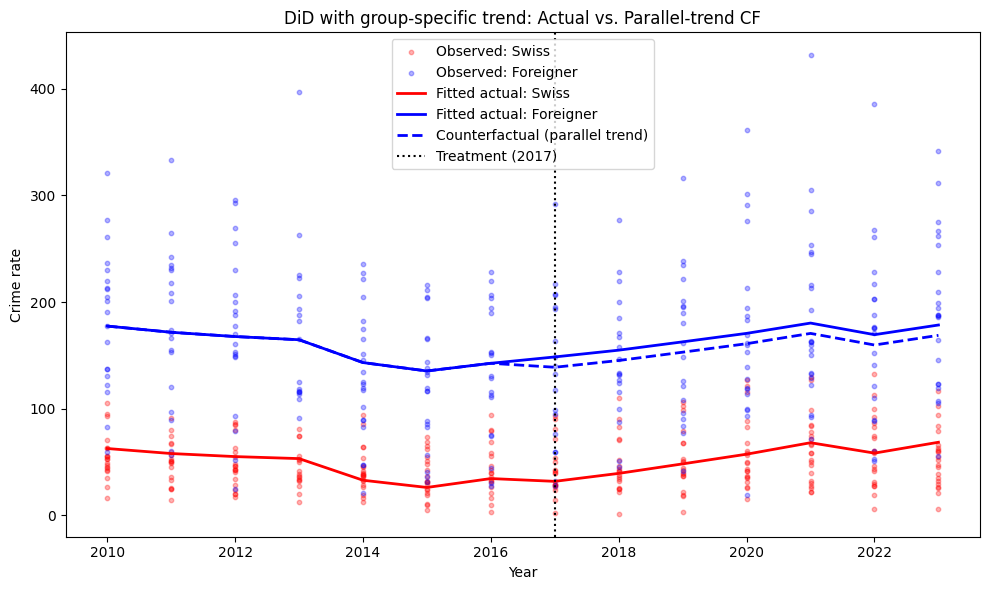

In [59]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('crime_rate_per_100k','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index()
)

plt.figure(figsize=(10,6))


for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['crime_rate_per_100k'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')


for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')


plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Crime rate')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.show()

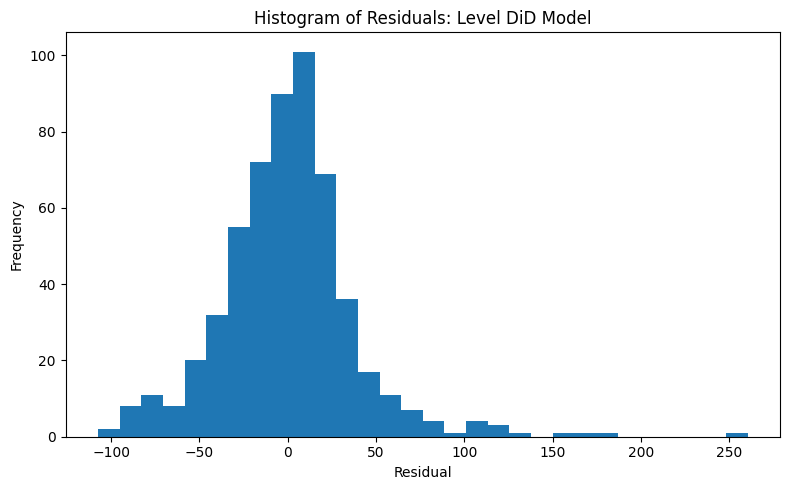

In [60]:
#Residual distribution
# Show a quick histogram of residuals for the level model—if they’re wildly skewed, that’s a strike for the log specification.
# -> residuals are normally distributed, most likely that linear specification is the correct

resid = mod2.resid

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(resid, bins=30)
plt.title("Histogram of Residuals: Level DiD Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Treat outliers

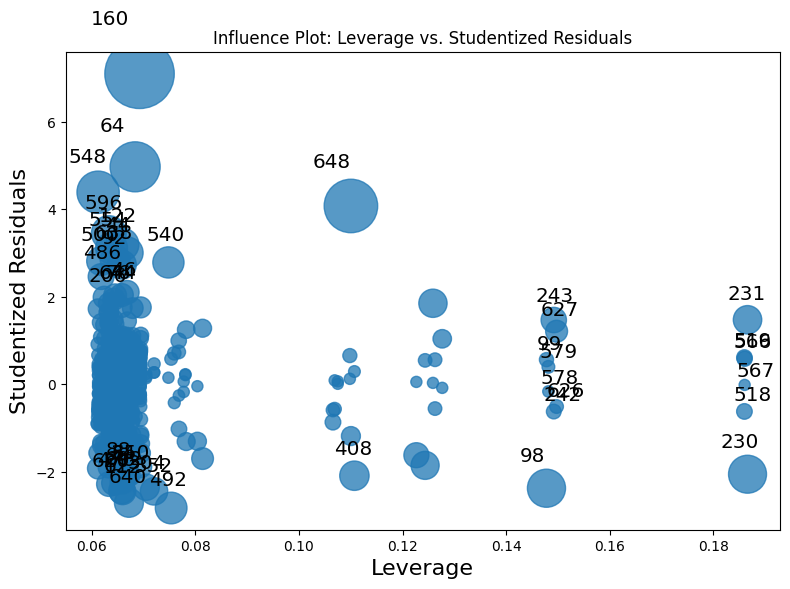


Top 5 Influential Observations by Cook's Distance:
     standard_resid  hat_diag   cooks_d
160        6.780881  0.069259  0.087732
648        4.017176  0.110045  0.051166
64         4.861630  0.068410  0.044503
548        4.315888  0.061266  0.031171
98        -2.362103  0.147777  0.024808


,group,canton,year,crime_rate_per_100k,log_rate,T_P
160,Foreigner,Jura,2013,396.904148,5.983695,0
648,Foreigner,Obwalden,2023,311.129967,5.740211,1
64,Foreigner,Jura,2011,333.440895,5.809466,0
548,Foreigner,Neuchâtel,2021,431.297377,6.066798,1
98,Foreigner,Appenzell Ausserrhoden,2012,24.624477,3.203741,0


In [61]:
#check for the heaviest outliers
# maybe we should try running a regression without em

infl = mod2.get_influence()

fig, ax = plt.subplots(figsize=(8, 6))
influence_plot(mod2, ax=ax, criterion="cooks", size=50)
ax.set_title("Influence Plot: Leverage vs. Studentized Residuals")
ax.set_xlabel("Leverage")
ax.set_ylabel("Studentized Residuals")
plt.tight_layout()
plt.show()


top5 = summary_frame.sort_values('cooks_d', ascending=False).head()
print("\nTop 5 Influential Observations by Cook's Distance:")
print(top5[['standard_resid', 'hat_diag', 'cooks_d']])

df_ct.loc[[160, 648, 64, 548, 98], ['group','canton','year','crime_rate_per_100k','log_rate','T_P']]


In [62]:
# error unbiased from outliers because of heteroskedasticity
mod2_hc3 = mod2.get_robustcov_results(cov_type='HC3')
print(mod2_hc3.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     65.75
Date:                 Sun, 11 May 2025   Prob (F-statistic):          2.86e-172
Time:                         18:47:42   Log-Likelihood:                -2817.1
No. Observations:                  556   AIC:                             5712.
Df Residuals:                      517   BIC:                             5881.
Df Model:                           38                                         
Covariance Type:                   HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [63]:
#Huber fit regression -> outlier robust
import statsmodels.api as sm

# 1) Build your design matrices (same as for mod2)
y, X = smf.ols("crime_rate_per_100k	 ~ T_P + T_t + C(group) + C(canton) + C(year)",
               data=df_ct, return_type='dataframe').endog, \
       smf.ols("crime_rate_per_100k	 ~ T_P + T_t + C(group) + C(canton) + C(year)",
               data=df_ct, return_type='dataframe').exog

# 2) Fit an RLM with Huber’s T norm (for example)
rlm_mod = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

print(rlm_mod.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  556
Model:                            RLM   Df Residuals:                      517
Method:                          IRLS   Df Model:                           38
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         
Time:                        18:47:42                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.5570      7.807     20.821      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['return_type']
  warnings.warn(msg, ValueWarning)
